In [7]:
%%local
!sudo apt-get install -y python-tk

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-tk is already the newest version.
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


# Predictive Maintenance Using IoT Sensor Data with Tensorflow

In this analysis we use streaming IoT sensors to track the state of a SCARA (Selective Compliance Assembly Robot Arm) Robot and predict anomalies that may indicate impending failure.

When an anomaly is detected, alerts can be sent to trigger maintenance request before the anomalous readings lead to failures.

In [8]:
%%local
import os
import pandas as pd
import csv
import numpy as np
import random
import glob
import matplotlib
import matplotlib.pyplot as plt
import random
import plotly
%matplotlib inline

#import tensorflow libraries
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

In [9]:
%%local
from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [10]:
%%local
#import the data from MapR-FS, super easy
#df = pd.read_csv("/user/user01/rw_etl.csv/part-00000-45866095-f76d-4f6c-ba2d-a07f0ab2dc04.csv").sort_values(['TimeStamp'], ascending=True).reset_index()

#TEMPORARY - load data from local container for testing purposes while cluster is down
df = pd.read_csv("tmp/data/part-00000-45866095-f76d-4f6c-ba2d-a07f0ab2dc04.csv").sort_values(['TimeStamp'], ascending=True).reset_index()

df.drop(['::[scararobot]Ax_J1.PositionCommand','::[scararobot]Ax_J1.TorqueFeedback','::[scararobot]Ax_J2.PositionCommand','::[scararobot]Ax_J2.TorqueFeedback','::[scararobot]Ax_J3.TorqueFeedback','::[scararobot]Ax_J6.TorqueFeedback','::[scararobot]ScanTimeAverage','::[scararobot]Ax_J6.PositionCommand','::[scararobot]Ax_J3.PositionCommand','index'], axis=1, inplace=True)
df['TimeStamp']=pd.to_datetime(df['TimeStamp'])
df.head(5)

In [13]:
%%local
# Create a trace
trace = go.Scatter(
    x = df['TimeStamp'],
    y = df['::[scararobot]Ax_J1.ActualPosition']
)

data = [trace]

iplot(data)


0         0.000000
1         0.000000
2        60.671337
3         0.000000
4        61.989475
5         0.000000
6        63.313774
7         0.000000
8        64.632004
9         0.000000
10       65.959091
11        0.000000
12       67.273468
13        0.000000
14       68.590889
15        0.000000
16       69.996185
17        0.000000
18       71.609428
19        0.000000
20       73.516426
21        0.000000
22       75.517540
23        0.000000
24       77.579041
25        0.000000
26       79.885864
27        0.000000
28       82.314842
29        0.000000
           ...    
81900     0.000000
81901    -6.303816
81902     0.000000
81903    -5.944032
81904     0.000000
81905    -5.659811
81906     0.000000
81907    -5.453226
81908     0.000000
81909    -5.322546
81910     0.000000
81911    -5.238414
81912     0.000000
81913    -7.489295
81914     0.000000
81915    -5.194260
81916     0.000000
81917    -5.188122
81918     0.000000
81919    -5.185026
81920     0.000000
81921    -5.

In [11]:
%%local
iplot(df['TimeStamp'], df['::[scararobot]Ax_J1.ActualPosition'])

PlotlyError: The `figure_or_data` positional argument must be either `dict`-like or `list`-like.

40965
[ 327.791445  328.576018  330.423442  333.020361  336.080585  340.781018
  336.463073  294.974023  231.794334  223.780527]
40965
[ 327.791445  328.576018  330.423442  333.020361  336.080585]
409
(409, 100, 1)
[ 328.576018  330.423442  333.020361 ...,  331.672992  329.66781
  326.960628]
40900
409
(1, 100, 1)
[[[-231.923638]]]
(1, 100, 1)
[[[-176.057844]]]


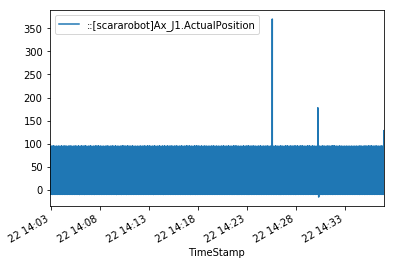

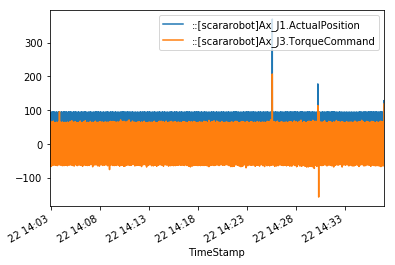

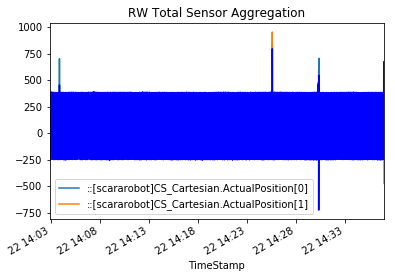

In [4]:
%%local

#plot some of the columns to get an idea of the trends over time
df.plot(x="TimeStamp", y="::[scararobot]Ax_J1.ActualPosition", kind="line")
df.plot(x="TimeStamp", y=["::[scararobot]Ax_J1.ActualPosition","::[scararobot]Ax_J3.TorqueCommand"], kind="line")
df.plot(x="TimeStamp", y=["::[scararobot]CS_Cartesian.ActualPosition[0]","::[scararobot]CS_Cartesian.ActualPosition[1]"], kind="line")

#remove rows that are all zeros
df1 = df[df["::[scararobot]speed"] != 0].set_index('TimeStamp')   
print (len(df1))

#create a new column that will be our feature variable for our model
#df1['total']=df1.sum(axis=1)
df1['Total']= df1.select_dtypes(include=['float64','float32']).apply(lambda row: np.sum(row),axis=1)

#convert into a time series object
ts = pd.Series(df1['Total'])
ts.plot(c='b', title='RW Total Sensor Aggregation')

#prepare data and inputs for our TF model
num_periods = 100
f_horizon = 1       #number of periods into the future we are forecasting
TS = np.array(ts)   #convert time series object to an array
print (TS[0:10])
print (len(TS))

#create our training input data set "X"
x_data = TS[:(len(TS)-(len(TS) % num_periods))]
print (x_data[0:5])
x_batches = x_data.reshape(-1, num_periods, 1)
print (len(x_batches))
print (x_batches.shape)
#print (x_batches[0:3])

#create our training output dataset "y"
y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
#print (y_data)
#print (len(y_data))
#y_data = TS[(num_periods+(f_horizon-1))::(num_periods)]
print (y_data)
print (len(y_data))
y_batches = y_data.reshape(-1, num_periods, 1)
print (len(y_batches))

#create our test X and y data
def test_data(series,forecast,num_periods):
    test_x_setup = series[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, num_periods, 1)
    testY = TS[-(num_periods):].reshape(-1, num_periods, 1)
    return testX,testY

X_test, Y_test = test_data(TS,f_horizon,num_periods)
print (X_test.shape)
print (X_test[:,(num_periods-1):num_periods])
print (Y_test.shape)
print (Y_test[:,(num_periods-1):num_periods])


In [8]:
%%local


#set up our TF model parameters

tf.reset_default_graph()   #We didn't have any previous graph objects running, but this would reset the graphs

inputs = 1            #number of vectors submitted
hidden = 100          #number of neurons we will recursively work through, can be changed to improve accuracy
output = 1            #number of output vectors

X = tf.placeholder(tf.float32, [None, num_periods, inputs], name = "X")   #create variable objects
y = tf.placeholder(tf.float32, [None, num_periods, output], name = "y")


basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)   #create our RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)               #choose dynamic over static

learning_rate = 0.001   #small learning rate so we don't overshoot the minimum
#tf.app.flags.DEFINE_float('learning_rate', 0.001, 'Initial learning rate.')

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])           #change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)        #specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])          #shape of results
 
loss = tf.reduce_sum(tf.square(outputs - y),name='loss')    #define the cost function which evaluates the quality of our model
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)          #gradient descent method
training_op = optimizer.minimize(loss)          #train the result of the application of the cost_function                                 

init = tf.global_variables_initializer()

epochs = 1000     #number of iterations or training cycles, includes both the FeedFoward and Backpropogation


with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse) 
            
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred[:,(num_periods-1):num_periods])
    
    saver = tf.train.Saver()   #we are going to save the model
    DIR="model"  #path where the model will be saved
    saver.save(sess, os.path.join(DIR,"RWsensorTFmodel"),global_step = epochs)




(0, '\tMSE:', 8.5685248e+08)
(100, '\tMSE:', 54943380.0)
(200, '\tMSE:', 44197612.0)
(300, '\tMSE:', 39632792.0)
(400, '\tMSE:', 36136824.0)
(500, '\tMSE:', 32122160.0)
(600, '\tMSE:', 28869502.0)
(700, '\tMSE:', 25817292.0)
(800, '\tMSE:', 23756384.0)
(900, '\tMSE:', 21982408.0)
[[[-109.04077911]]]


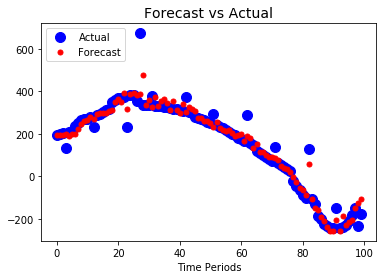

In [9]:
%%local

#Plot our test y data and our y-predicted forecast
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual")
#plt.plot(pd.Series(np.ravel(Y_test)), "w*", markersize=10)
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")
plt.show()